# Introductory tutorial for PASTAQ DDA data exploration and processing
## Load pastaq and raw data
This tutorial shows the basic functionality of PASTAQ library provided by python binding.

First load pastaq as well other packages for visualisation and some basic data analysis. Then load the LC-MS(/MS) file in mzML or mzXML format using the `read_mzml` or `read_mzxml` function. Set the average full width at half maximum (`avg_fwhm_rt`) of the chromatographic peak. Then load the default parameters for Orbitrap using `default_parameters` function and change required parameters (in this case MS2 resolution).

In [3]:
import pastaq as pq

In [13]:
!pwd

/home/jovyan/work/github/PASTAQ/examples


In [14]:
import pastaq as pq
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from helpers import interpolate_values, find_closest_peak, plot_gaussian, plot_msSpectra

# file name and location of the example files (add a proper data_dir path)
sample_data_dir = '../../../data/pastaq/'
exampleFile1 = sample_data_dir + '3_1_extract_3400_4100_590_615.mzML'
exampleFile2 = sample_data_dir + '3_2_extract_3400_4100_590_615.mzML'

avg_fwhm_rt = 25 # default 15

# load example file
# TODO: manage to accept default parameters
lcmsData1 = pq.read_mzxml2(exampleFile1, min_mz = -1.0, max_mz = -1.0, 
                           min_rt = -1.0, max_rt = -1.0, instrument_type = 'orbitrap', 
                           resolution_ms1 = 17500, resolution_msn = 17500, reference_mz = 0, 
                           fwhm_rt = avg_fwhm_rt, ms_level = 1)
# lcmsDataMS2_1 = pq.read_mzxml2(exampleFile1, fwhm_rt = avg_fwhm_rt, ms_level = 2)
# lcmsData2 = pq.read_mzxml2(exampleFile2, fwhm_rt = avg_fwhm_rt, ms_level = 1)
# lcmsDataMS2_2 = pq.read_mzxml2(exampleFile2, fwhm_rt = avg_fwhm_rt, ms_level = 2)
params = pq.default_parameters(avg_fwhm_rt = avg_fwhm_rt)
params['resolution_msn'] = 17500
print(params)

Scan Number: 25483, Offset: 5662
Scan Number: 25488, Offset: 23857
Scan Number: 25495, Offset: 42658
Scan Number: 25498, Offset: 61389
Scan Number: 25505, Offset: 117968
Scan Number: 25511, Offset: 136375
Scan Number: 25521, Offset: 173714
Scan Number: 25524, Offset: 192961
Scan Number: 25528, Offset: 245468
Scan Number: 25535, Offset: 303710
Scan Number: 25538, Offset: 320371
Scan Number: 25546, Offset: 338299
Scan Number: 25550, Offset: 395535
Scan Number: 25553, Offset: 414230
Scan Number: 25561, Offset: 431796
Scan Number: 25566, Offset: 449865
Scan Number: 25571, Offset: 466773
Scan Number: 25576, Offset: 483160
Scan Number: 25585, Offset: 500462
Scan Number: 25596, Offset: 516892
Scan Number: 25605, Offset: 534697
Scan Number: 25608, Offset: 550919
Scan Number: 25615, Offset: 569085
Scan Number: 25617, Offset: 604169
Scan Number: 25624, Offset: 621031
Scan Number: 25635, Offset: 638525
Scan Number: 25638, Offset: 654698
Scan Number: 25649, Offset: 672855
Scan Number: 25652, Offse

## Print the main characteristics of LC-MS(/MS) data and the first 20 intensities of the MS1 spectra with id of 20.

Main characteristics of LCMS data:
 <bound method PyCapsule.dump of RawData:
> instrument_type: ORBITRAP
> resolution_ms1: 17500.000000
> resolution_msn: 17500.000000
> reference_mz: 0.000000
> min_mz: 99.004356
> max_mz: 2550.948980
> min_rt: 3400.143127
> max_rt: 4098.910675
> number of scans: 1156> 

First 20 intensity of scan  15 :
 [123137.6640625, 198857.796875, 186504.703125, 110450.796875, 30861.353515625, 51615.1875, 93108.640625, 108093.6484375, 77396.5, 24463.44921875, 29560.482421875, 76585.5234375, 94415.8671875, 70456.1171875, 33264.14453125, 54325.26953125, 121243.7578125, 180292.203125, 110860.3984375]
0.00455 0.006801232948532743 0.011351232948532743 0.0035
0.00455 0.00680158542195386 0.01135158542195386 0.0035
0.00455 0.004569818341565224 0.009119818341565224 0.0035
0.00455 0.00688235115740099 0.01143235115740099 0.0035


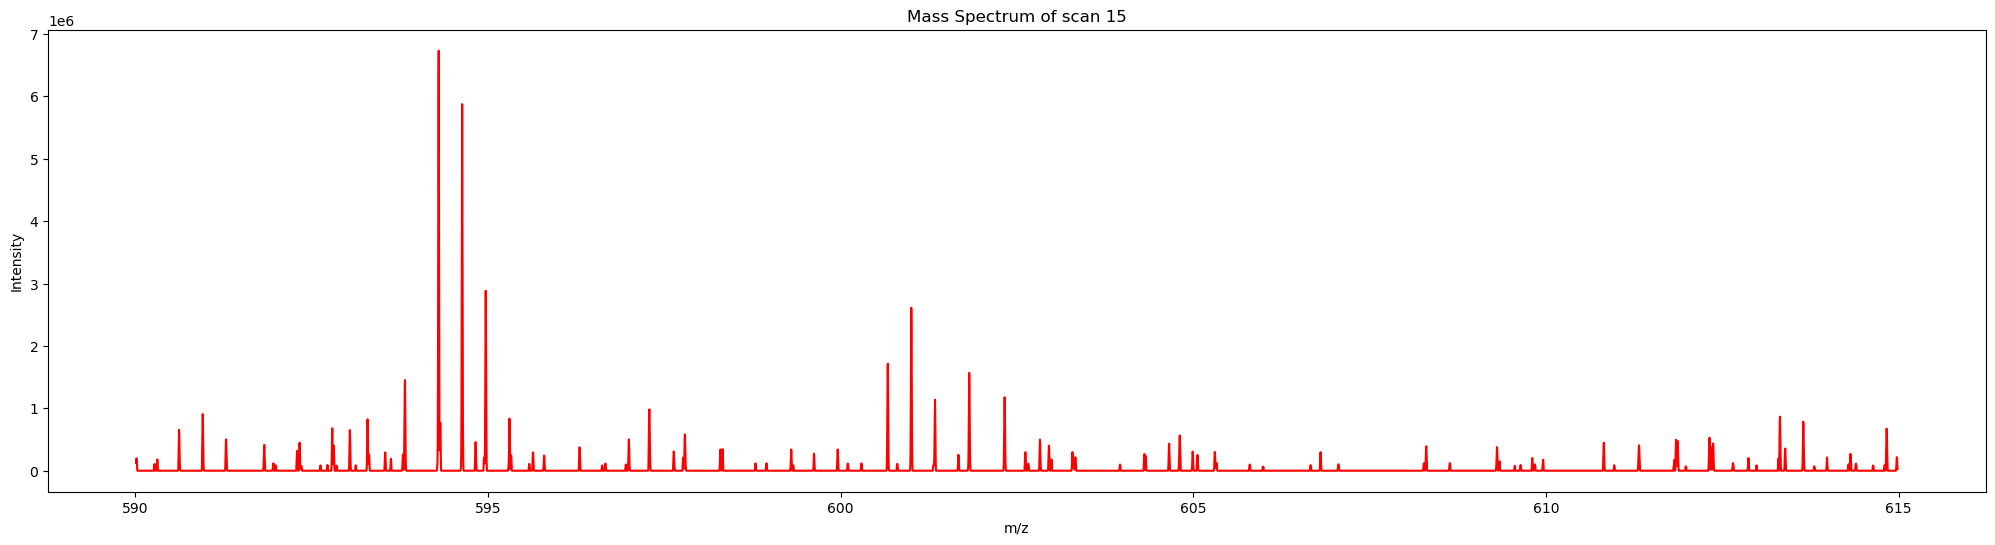

In [16]:
scanIdx = 15
print('Main characteristics of LCMS data:\n', lcmsData1.dump, '\n')
print('First 20 intensity of scan ', scanIdx, ':\n', lcmsData1.scans[scanIdx].intensity[1:20])
figMS = plot_msSpectra(lcmsData1.scans[scanIdx].mz, lcmsData1.scans[scanIdx].intensity, 0.0035, 1.3, scanIdx)

Zoom in of the spectra with defined range.

0.00455 0.006801648675946126 0.011351648675946126 0.0035
0.00455 0.006813180085828208 0.011363180085828208 0.0035
0.00455 0.004618230231130838 0.009168230231130838 0.0035
0.00455 0.006897045089317544 0.011447045089317544 0.0035
0.00455 0.00693177476944129 0.01148177476944129 0.0035
0.00455 0.006976202107352947 0.011526202107352947 0.0035
0.00455 0.006992340688043441 0.011542340688043442 0.0035


(594.0, 597.0)

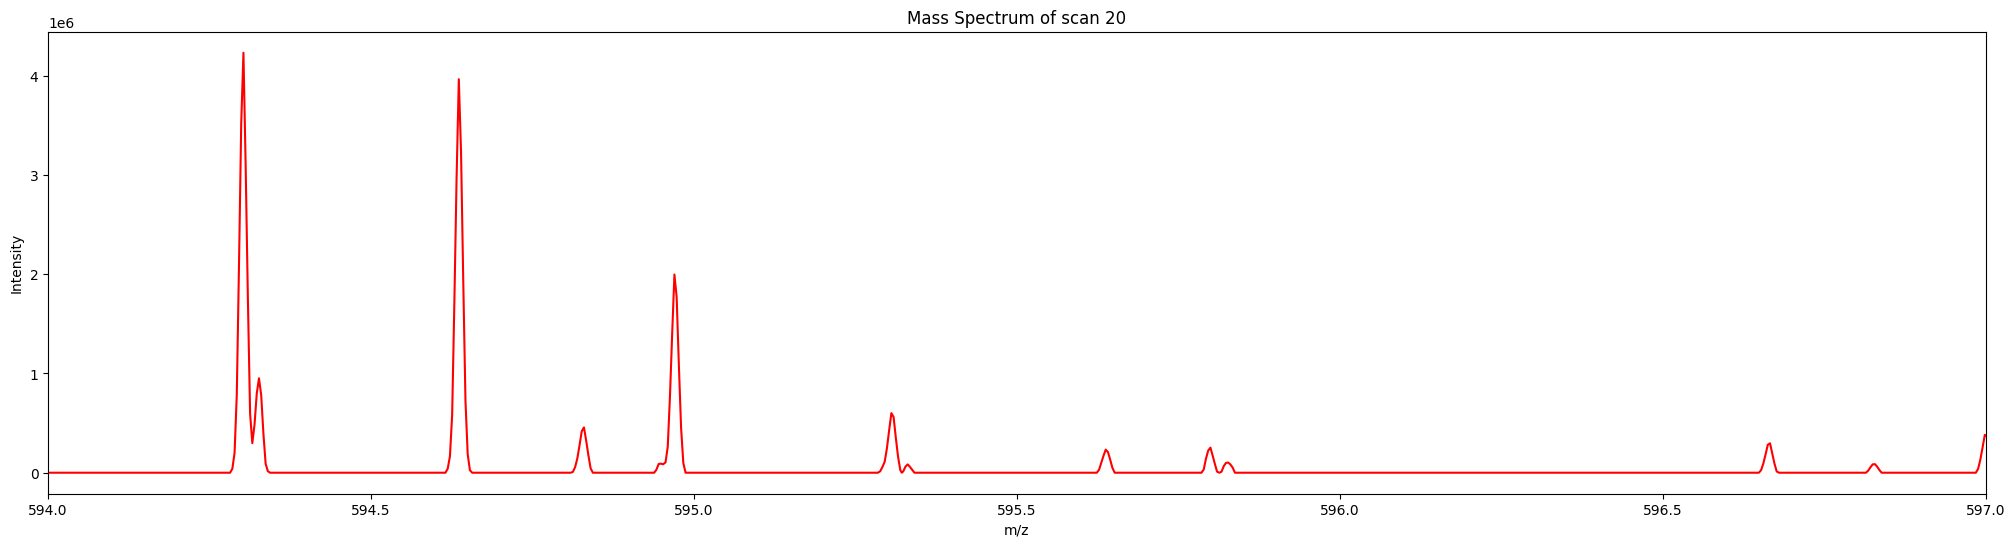

In [3]:
# zoom in on a specific mz range
figMS = plot_msSpectra(lcmsData1.scans[scanIdx].mz, lcmsData1.scans[scanIdx].intensity, 0.0035, 1.3, scanIdx)
figMS.get_axes()[0].set_xlim(594,597)
# help(pq.resample)

## Perform smoothing and resampling of MS1 data using 2D Gaussian kernel density
- Perform the smoothing with the `resample` function.
- Plot the smooth and resampled data as a heatmap showing TIC and spectral sum with the `plot_mesh` function.

The similar peak pattern and the 120 second retention time shift are visible in the smooth figure.

First dataset


{'img_plot': <Axes: xlabel='m/z', ylabel='retention time (s)'>,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intens'>}

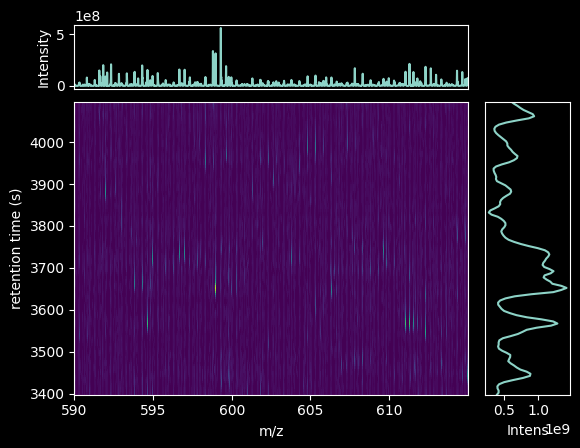

In [5]:
grid1 = pq.resample(lcmsData1, params['num_samples_mz'], params['num_samples_rt'], params['smoothing_coefficient_mz'], params['smoothing_coefficient_rt'])
grid2 = pq.resample(lcmsData2, params['num_samples_mz'], params['num_samples_rt'], params['smoothing_coefficient_mz'], params['smoothing_coefficient_rt'])

# plot the smoothed LC-MS map for dataset 1
print('First dataset')
pq.plot_mesh(grid1, transform='sqrt', figure=None)

Second dataset


{'img_plot': <Axes: xlabel='m/z', ylabel='retention time (s)'>,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intens'>}

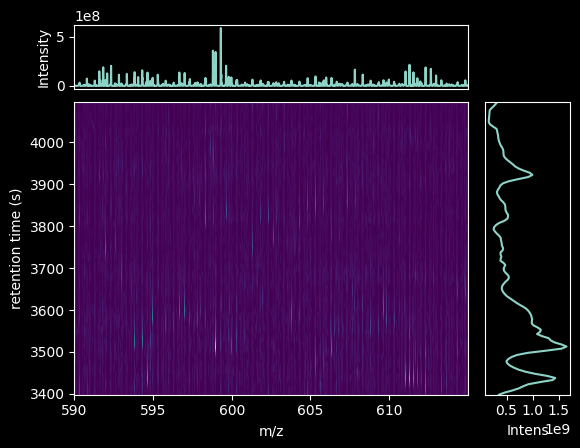

In [5]:
# plot the smoothed LC-MS map for dataset 2
print('Second dataset')
pq.plot_mesh(grid2, transform='sqrt', figure=None)

## Show peak detection of an isotopologue in the form of a 2D Gaussian peak and visualize the detected peak.
Use `find_peaks` for peak detection based on a fast 2D Gaussian fit to the local maxima identified in a smoothed LC-MS grid. The grid is derived from the raw data based on a 2D kernel density smoothing of the raw LC-MS data.  The maximum number of detected peaks can be specified and the output list may be smaller if not all peaks are detected.

Here we printing the first (most abundant) peaks from peak list of both files.<br>

Extracted ion chromatogram (EIC) showing maximum intensity is plotted with the `plot_xic` function.

Plot the raw data points as well as TIC and the summed spectra of peak with index 20 using `plot_peak_raw_points` function.

Peak <id: 0, local_max_mz: 598.969421, local_max_rt: 3654.694083, local_max_height: 48604413.414760, fitted_height: 64467671.670919, fitted_mz: 598.970156, fitted_rt: 3653.005007, fitted_sigma_mz: 0.005523, fitted_sigma_rt: 9.542328, fitted_volume: 21349410.526087>
Peak <id: 0, local_max_mz: 599.304356, local_max_rt: 3515.300296, local_max_height: 58808916.485232, fitted_height: 67259702.463243, fitted_mz: 599.303816, fitted_rt: 3516.811830, fitted_sigma_mz: 0.005471, fitted_sigma_rt: 12.973675, fitted_volume: 29996968.902009>


{'img_plot': <Axes: >,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intensity'>}

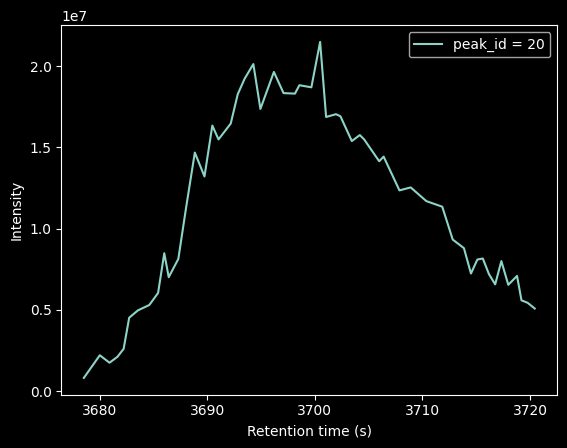

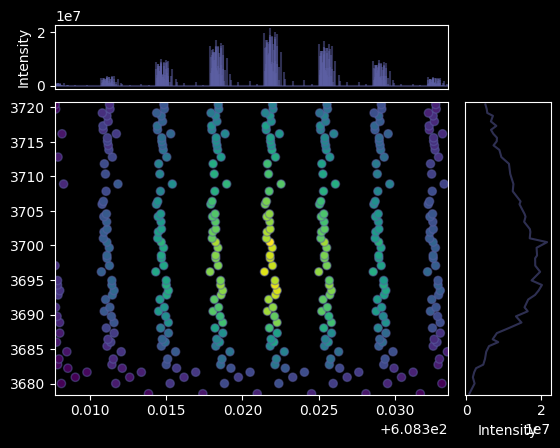

In [6]:
peaks1 = pq.find_peaks(lcmsData1, grid1, params['max_peaks'])
peaks2 = pq.find_peaks(lcmsData2, grid2, params['max_peaks'])

print(peaks1[0])
print(peaks2[0])

# plot the EIC of the peak with index 20.
fill_alpha = params['qc_plot_fill_alpha']
line_alpha = params['qc_plot_line_alpha']
scatter_alpha = params['qc_plot_scatter_alpha']
palette = sns.color_palette(params['qc_plot_palette'], 10)
pq.plot_xic(peaks1[20], lcmsData1, figure=None, method="max")

# plot the peak raw points with TIC in total ion spectra
pq.plot_peak_raw_points(peaks1[20], lcmsData1, img_plot=None, rt_plot=None, mz_plot=None, xic_method="max")

## Visualize the raw data EIC and smoothed map showing the fit to a peak with given index
First, limits for mz width with given a number of sigma are calculated as well the retention time window. With these limits the `pq.xic` function yields an extraction ion chromatogram in the retention time range. Next, using limits from the smoothed LC-MS1 and previous mz range, the EIC trace is calculated and visualised. Finally, the location of the peak is indicated by a vertical green line along with the Gaussian fit to the detected peak.

You can set the variable `peakIdx` to various values to visualize other peaks. Since peaks are sorted according to intensity, index 0 refers to the highest and the last index refers to the lowest abundant peak. You can also explore the impact of the variable `sigmaFactor`, which sets the width of EICs in numbers of fitted mz sigma of the Gaussian peak. A value of 0.25 gives more or less local intensity, and a value of 1 corresponds to a larger range and less noisy raw data EIC.


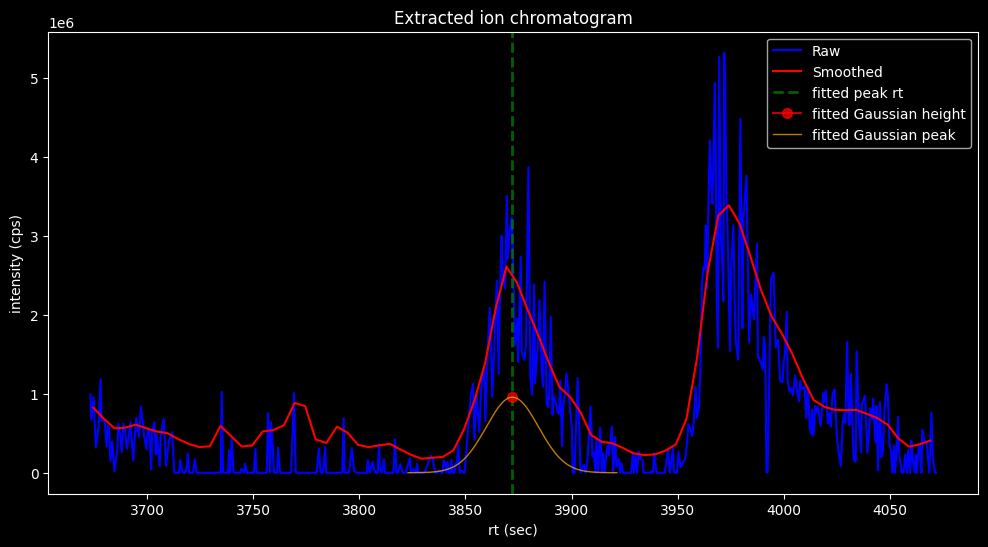

In [7]:
peakIdx = 412
sigmFactor = 1 #0.25 gives more or less local intensity, 1 give larger range and less noise raw data EIC
rtWidthEIC = 200 # rt width of EICs

lowBoundmz = peaks1[peakIdx].fitted_mz-sigmFactor*peaks1[peakIdx].fitted_sigma_mz
highBoundmz = peaks1[peakIdx].fitted_mz+sigmFactor*peaks1[peakIdx].fitted_sigma_mz
lowBoundrt = peaks1[peakIdx].fitted_rt - rtWidthEIC
highBoundrt = peaks1[peakIdx].fitted_rt + rtWidthEIC
xic1 = pq.xic(lcmsData1, lowBoundmz, highBoundmz, lowBoundrt, highBoundrt)

np.array(grid1.bins_mz, dtype=np.float64)
indices_mz1 = [i for i, val in enumerate(np.array(grid1.bins_mz, dtype=np.float64)) if lowBoundmz < val < highBoundmz]
indices_rt1 = [i for i, val in enumerate(np.array(grid1.bins_rt, dtype=np.float64)) if lowBoundrt < val < highBoundrt]
xicGrid = np.array(grid1.data).reshape(grid1.m, grid1.n)
xicGridi1 = xicGrid[indices_rt1][:, indices_mz1]
xicGridis1 = np.sum(xicGridi1, axis=1)
xicGridrt1 = np.array(grid1.bins_rt, dtype=np.float64)[indices_rt1]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(xic1.retention_time, xic1.intensity, label='Raw', alpha=1, color='blue')
plt.plot(xicGridrt1, xicGridis1, label='Smoothed', alpha=1, color='red')
plt.axvline(x=peaks1[peakIdx].fitted_rt, label='fitted peak rt', color='green', alpha=0.75, linestyle='--', linewidth=2)
plt.plot(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='red', alpha=0.75)

# Plot the Gaussian peak
plot_gaussian(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_sigma_rt, peaks1[peakIdx].fitted_height)

plt.xlabel('rt (sec)')
plt.ylabel('intensity (cps)')
plt.title('Extracted ion chromatogram')
plt.legend()

# show the plot
plt.show()

## Detect features and link MS/MS to MS1 peaks
First, features (isotope clusters) are detected using the averagine model. Then we show the characteristics of the first isotope cluster for both example datasets.

Subsequently the MS/MS events are linked to the peaks using proximity expressed in terms of number of sigma. This is followed by showing the characteristics of the first isotope cluster for both example datasets. Using the linked MS/MS event to peaks and the linked peaks (isotopologues) in features it is possible to get MS/MS linked to features. Linking identification results to MS/MS events allows the assessment of the consistency of identification in DDA experiments.

In [8]:
# detecting features
features1 = pq.detect_features(peaks1, params['feature_detection_charge_states'])
features2 = pq.detect_features(peaks2, params['feature_detection_charge_states'])
print("First isotope cluster (feature) in dataset 1:", features1[0])
print("First isotope cluster (feature) in dataset 2:", features2[0])

# linking MS/MS events to peaks.
linked_msms1 = pq.link_peaks(peaks1, lcmsDataMS2_1, params['link_n_sig_mz'], params['link_n_sig_rt'])
linked_msms2 = pq.link_peaks(peaks2, lcmsDataMS2_2, params['link_n_sig_mz'], params['link_n_sig_rt'])
print("First linked MS/MS event in dataset 1:", linked_msms1[0])
print("First linked MS/MS event in dataset 1:", linked_msms2[0])

First isotope cluster (feature) in dataset 1: Feature <id: 0, average_rt: 3653.788129, average_mz: 599.325806, total_height: 176476145.747553, monoisotopic_mz: 598.970156, monoisotopic_height: 64467671.670919, charge_state: 3, n_isotopes: 7>
First isotope cluster (feature) in dataset 2: Feature <id: 0, average_rt: 3515.571494, average_mz: 599.328879, total_height: 189580918.037741, monoisotopic_mz: 598.969689, monoisotopic_height: 67078702.311875, charge_state: 3, n_isotopes: 7>
First linked MS/MS event in dataset 1: LinkedMsms <entity_id: 0, scan_index: 103, msms_id: 391, distance: 2.201093>
First linked MS/MS event in dataset 1: LinkedMsms <entity_id: 0, scan_index: 47, msms_id: 196, distance: 0.593648>


## Time align two LC-MS peak lists
First, a map holding the piece-wise alignment between two peaks list is calculated using the `calculate_time_map` function, which has the following parameters:

1. The reference peak list
1. The sample peak list
1. slack: a parameter specifying how far the end of each segment can shift during alignment in "points"
1. segment_length representing the number of "points" in each segment used for alignment
1. num_points: the total number of "points" in the chromatogram.  Dividing this by segment_length gives the number of segments
1. expand_factor: a factor that allows the chromatogram to expand in order to allow space to accommodate the alignment
1. peaks_per_window: the number of primary peaks in each segment to use for alignment

Then the retention time of the sample peak list is aligned to the reference according to the time map function using the `warp_peaks` function.

The similarity between sample peak list and the reference before and after alignment is calculated using the `find_similarity` function.

The small value of the similarity score indicates a large time discrepancy between peak lists 1 and 2 prior to alignment, but the large boost in the similarity score after alignment shows that it worked.

Feel free to experiment with the parameters to learn how they impact the overall similarity of LC-MS/MS map after alignment.

In [9]:
# calculate alignment time map (piece-wise linear alignment function) between peak1 (not altered and used as reference) and peak2 (sample peak list, which will change retention time)
time_map_1r_2s = pq.calculate_time_map(peaks1, peaks2, 5, 10, 500, 0.2, 20)

# align peaks2 to peaks1 using the calculated time map
peaks2_1r = pq.warp_peaks(peaks2, time_map_1r_2s)

# calculate similarity matrix before and after warping between peak list 1 and 2
print("Raw data similarity: {:.5f}".format(pq.find_similarity(peaks1, peaks2,params['similarity_num_peaks']).geometric_ratio))
print("Similarity after alignment: {:.5f}".format(pq.find_similarity(peaks1, peaks2_1r,params['similarity_num_peaks']).geometric_ratio))

Raw data similarity: 0.07085
Similarity after alignment: 0.87343


## Show the effect of alignment on the original and aligned EIC for a peak in dataset 2 matched to a reference peak in dataset 1.
This plot shows the reference EIC for the peak selected using `peakIdx` variable above as blue trace in dataset 1, with the EIC of the matched peak in the raw (red) and aligned (green) dataset 2. The dots correspond to the reference peak (dataset 1 in blue), the matched peaks in dataset 2 in the raw data (red) and after alignment (green). The `interpolate_value` function available in `helpers.py` interpolates the retention time values of EIC, which allows visualisation of the EIC in dataset 2 aligned to the retention time of dataset 1.

Raw data similarity: {}Peak <id: 155, local_max_mz: 614.838085, local_max_rt: 3549.878931, local_max_height: 2320983.763784, fitted_height: 2869797.871078, fitted_mz: 614.838210, fitted_rt: 3551.959701, fitted_sigma_mz: 0.005780, fitted_sigma_rt: 10.402839, fitted_volume: 1084166.580670>
Raw data similarity: {}Peak <id: 112, local_max_mz: 614.838226, local_max_rt: 3420.423585, warped_rt: 3549.585229 (129.161644), local_max_height: 2545291.369142, fitted_height: 3107350.906077, fitted_mz: 614.837770, fitted_rt: 3422.614966, fitted_sigma_mz: 0.005834, fitted_sigma_rt: 10.202981, fitted_volume: 1162086.455774>


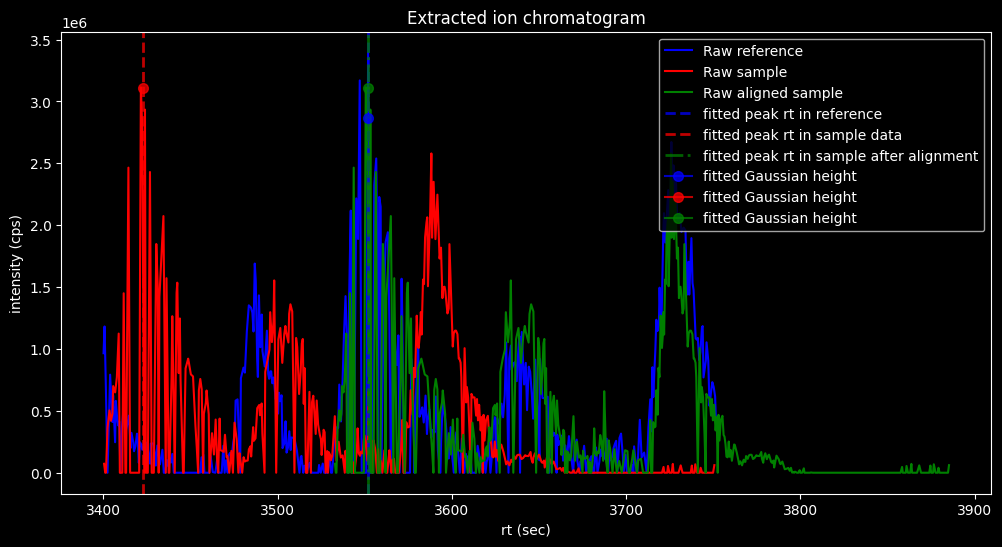

In [10]:
# get extracted ion chromatogram for file 2 using the same mz and rt range as for file 1
xic2 = pq.xic(lcmsData2, lowBoundmz, highBoundmz, lowBoundrt, highBoundrt)

# get matching peak for peaks1[peakIdx] in peaks2_1r
matchedpeak = find_closest_peak(peaks1[peakIdx], peaks2_1r)

# print target peaks and matched peaks in the other chromatograms
print("Raw data similarity: {}" + format(peaks1[peakIdx]))
print("Raw data similarity: {}" + format(matchedpeak))

alignedRTs = interpolate_values(xic2.retention_time, time_map_1r_2s.sample_rt_start, time_map_1r_2s.sample_rt_end, time_map_1r_2s.rt_start, time_map_1r_2s.rt_end)

#plot the raw EIC in the reference (blue) and sample data (red), and the aligned EIC in the sample data (green)
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(xic1.retention_time, xic1.intensity, label='Raw reference', alpha=1, color='blue')
plt.plot(xic2.retention_time, xic2.intensity, label='Raw sample', alpha=1, color='red')
plt.plot(alignedRTs, xic2.intensity, label='Raw aligned sample', alpha=1, color='green')
plt.axvline(x = peaks1[peakIdx].fitted_rt, label='fitted peak rt in reference', color='blue', alpha=0.75, linestyle='--', linewidth=2)
if matchedpeak!=None:
    plt.axvline(x = matchedpeak.fitted_rt, label='fitted peak rt in sample data', color='red', alpha=0.75, linestyle='--', linewidth=2)
    plt.axvline(x = (matchedpeak.fitted_rt + matchedpeak.rt_delta), label='fitted peak rt in sample after alignment', color='green', alpha=0.75, linestyle='-.', linewidth=2)
plt.plot(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='blue', alpha=0.75)
if matchedpeak!=None:
    plt.plot(matchedpeak.fitted_rt, matchedpeak.fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='red', alpha=0.75)
    plt.plot((matchedpeak.fitted_rt + matchedpeak.rt_delta), matchedpeak.fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='green', alpha=0.75)
plt.xlabel('rt (sec)')
plt.ylabel('intensity (cps)')
plt.title('Extracted ion chromatogram')
plt.legend()

# show the plot
plt.show()

Number of peaks in the feature:  6
Detected peaks in the feature:  [24, 29, 53, 150, 369, 1133]


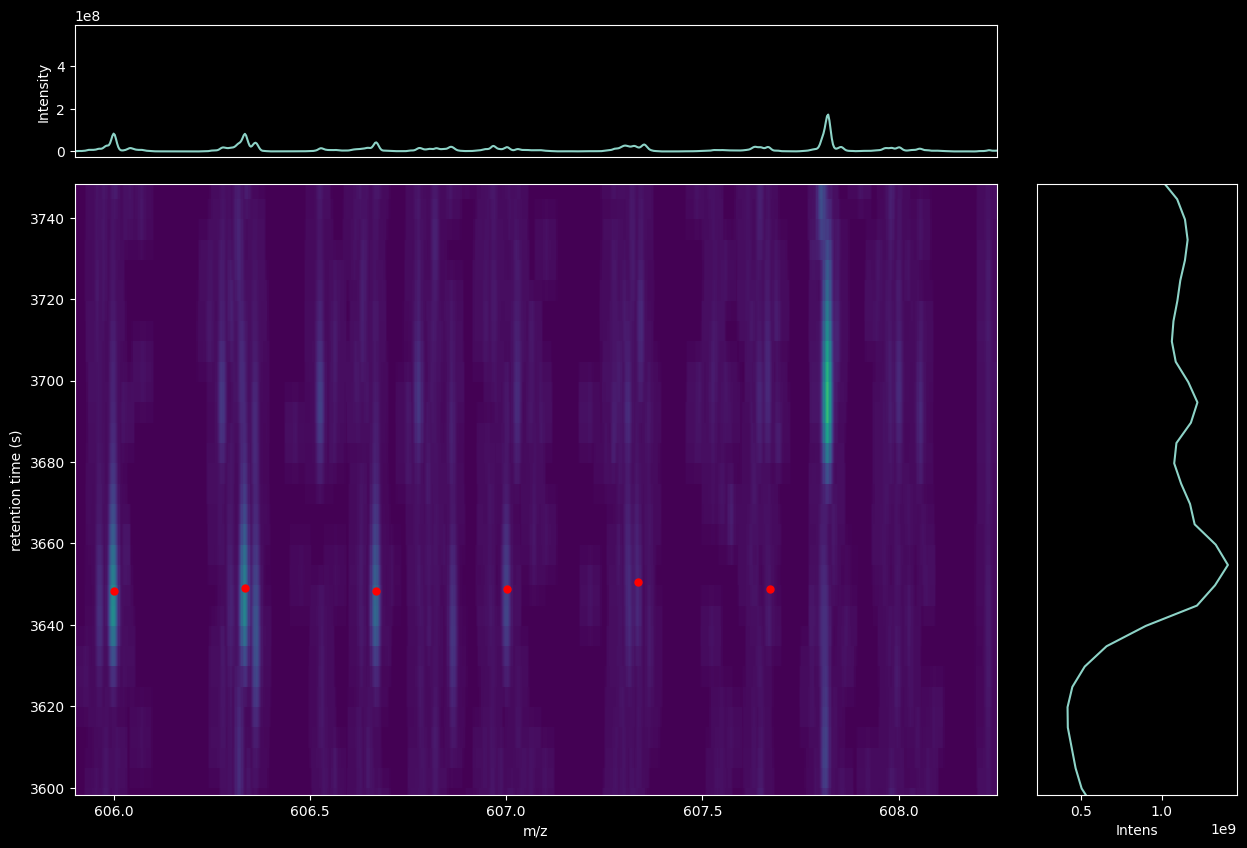

In [10]:
# show zoom in isotope cluster with detected peaks
peak1Idx = 24
rtp = 100 # retention in seconds added to isotope cluster monoisotopic peak m/z value (define the positive extension range of the plot in retention time)
rtm = 50 # retention in seconds substracted to isotope cluster monoisotopic peak m/z value (define the negative extension range of the plot in retention time)
mzm = 0.1 # m/z in Da added to isotope cluster monoisotopic peak m/z value (define the positive extension range of the plot in m/z)
mzp = 2.25 # m/z in Da substracted to isotope cluster monoisotopic peak m/z value (define the negative extension range of the plot in m/z)
plot1 = pq.plot_mesh(grid1, transform='sqrt', figure=None)
plot1['img_plot'].get_figure().set_size_inches(15, 10)
xlim1 = plot1['img_plot'].get_xlim()
ylim1 = plot1['img_plot'].get_ylim()
plot1['img_plot'].set_xlim(peaks1[peak1Idx].fitted_mz-mzm, peaks1[peak1Idx].fitted_mz+mzp)
plot1['img_plot'].set_ylim(peaks1[peak1Idx].fitted_rt-rtm, peaks1[peak1Idx].fitted_rt+rtp)
plot1['mz_plot'].set_xlim(peaks1[peak1Idx].fitted_mz-mzm, peaks1[peak1Idx].fitted_mz+mzp)
plot1['rt_plot'].set_ylim(peaks1[peak1Idx].fitted_rt-rtm, peaks1[peak1Idx].fitted_rt+rtp)
featuresList = [obj for obj in features1 if peak1Idx in obj.peak_ids]
if len(featuresList) > 1:
    print('More than one feature detected for the peak')
    featuresList = [featuresList[0]]
mzVec = []
rtVec = []
print('Number of peaks in the feature: ', len(featuresList[0].peak_ids))
print('Detected peaks in the feature: ', featuresList[0].peak_ids)
for i in featuresList[0].peak_ids:
    mzVec.insert(i, peaks1[i].fitted_mz)
    rtVec.insert(i, peaks1[i].fitted_rt)
plot1['img_plot'].scatter(mzVec, rtVec, s=100, c='red', marker='.')

Number of peaks in the feature:  6
Detected peaks in the feature:  [24, 29, 53, 150, 369, 1133]


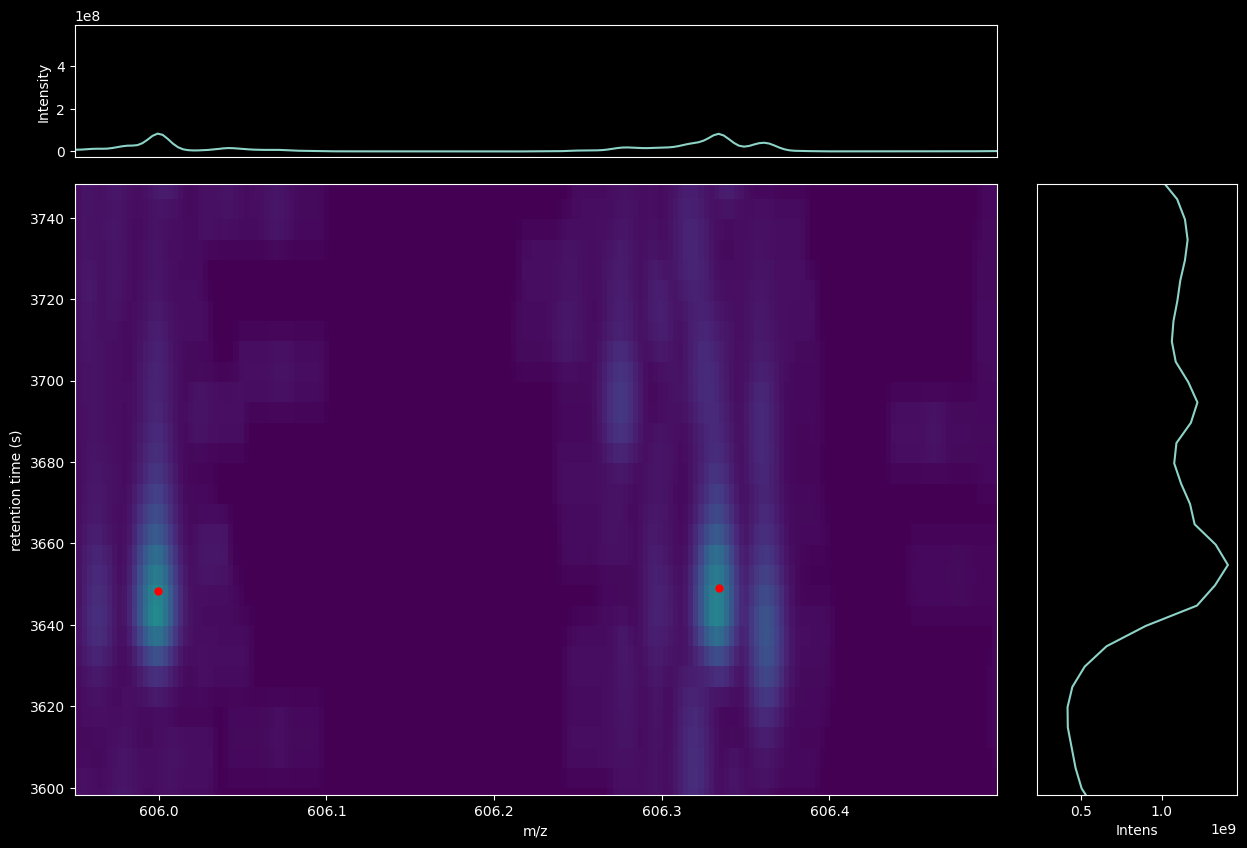

In [11]:
# zoom in to monoisotopic peak
rtp = 100 # retention in seconds added to isotope cluster monoisotopic peak m/z value (define the positive extension range of the plot in retention time)
rtm = 50 # retention in seconds substracted to isotope cluster monoisotopic peak m/z value (define the negative extension range of the plot in retention time)
mzm = 0.05 # m/z in Da added to isotope cluster monoisotopic peak m/z value (define the positive extension range of the plot in m/z)
mzp = 0.5 # m/z in Da substracted to isotope cluster monoisotopic peak m/z value (define the negative extension range of the plot in m/z)

# zoomed mesh area showing only the isotope cluster peaks
plot1 = pq.plot_mesh(grid1, transform='sqrt', figure=None)
plot1['img_plot'].get_figure().set_size_inches(15, 10)
xlim1 = plot1['img_plot'].get_xlim()
ylim1 = plot1['img_plot'].get_ylim()
plot1['img_plot'].set_xlim(peaks1[peak1Idx].fitted_mz-mzm, peaks1[peak1Idx].fitted_mz+mzp)
plot1['img_plot'].set_ylim(peaks1[peak1Idx].fitted_rt-rtm, peaks1[peak1Idx].fitted_rt+rtp)
plot1['mz_plot'].set_xlim(peaks1[peak1Idx].fitted_mz-mzm, peaks1[peak1Idx].fitted_mz+mzp)
plot1['rt_plot'].set_ylim(peaks1[peak1Idx].fitted_rt-rtm, peaks1[peak1Idx].fitted_rt+rtp)
featuresList = [obj for obj in features1 if peak1Idx in obj.peak_ids]
if len(featuresList) > 1:
    print('More than one feature detected for the peak')
    featuresList = [featuresList[0]]
mzVec = []
rtVec = []
print('Number of peaks in the feature: ', len(featuresList[0].peak_ids))
print('Detected peaks in the feature: ', featuresList[0].peak_ids)
for i in featuresList[0].peak_ids:
    mzVec.insert(i, peaks1[i].fitted_mz)
    rtVec.insert(i, peaks1[i].fitted_rt)
plot1['img_plot'].scatter(mzVec, rtVec, s=100, c='red', marker='.')

Peak <id: 0, local_max_mz: 606.001192, local_max_rt: 3648.341180, local_max_height: 11153871.858379, fitted_height: 15457606.136873, fitted_mz: 605.999697, fitted_rt: 3648.167246, fitted_sigma_mz: 0.005606, fitted_sigma_rt: 8.590545, fitted_volume: 4677407.324631>
Number of peaks:  14


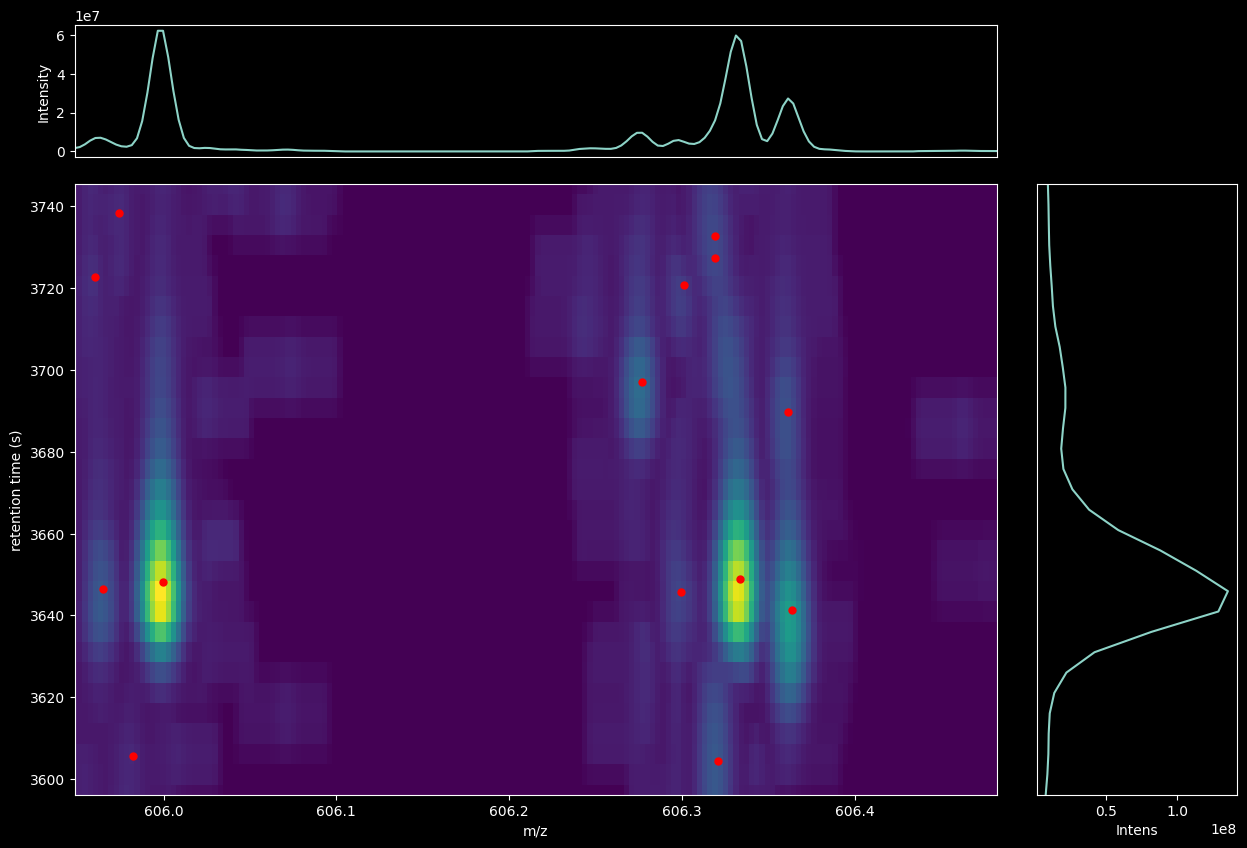

In [12]:
# Rereading the file with the mz and rt range zoomed to a peak area
lcmsData1r = pq.read_mzml(input_file = exampleFile1, min_mz = peaks1[peak1Idx].fitted_mz-mzm, max_mz = peaks1[peak1Idx].fitted_mz+mzp, min_rt = peaks1[peak1Idx].fitted_rt-rtm, max_rt = peaks1[peak1Idx].fitted_rt+rtp, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 1)
# resampling with 10 sampling points per peak
grid1r = pq.resample(lcmsData1r, 5, 5, 0.4, 0.4) #num_samples_mz, num_samples_rt, smoothing_coefficient_mz, smoothing_coefficient_rt
peaks1r = pq.find_peaks(lcmsData1r, grid1r, params['max_peaks'])
plot1r = pq.plot_mesh(grid1r, transform='sqrt', figure=None)
plot1r['img_plot'].get_figure().set_size_inches(15, 10)
xlim1r = plot1r['img_plot'].get_xlim()
ylim1r = plot1r['img_plot'].get_ylim()
mzVec1r = []
rtVec1r = []
print(peaks1r[0])
print('Number of peaks: ', len(peaks1r))
for i in range(len(peaks1r)):
    mzVec1r.insert(i, peaks1r[i].fitted_mz)
    rtVec1r.insert(i, peaks1r[i].fitted_rt)
plot1r['img_plot'].scatter(mzVec1r, rtVec1r, s=100, c='red', marker='.')

Peak <id: 0, local_max_mz: 605.999685, local_max_rt: 3645.853351, local_max_height: 11494547.635478, fitted_height: 15769714.365764, fitted_mz: 605.999718, fitted_rt: 3648.263887, fitted_sigma_mz: 0.005582, fitted_sigma_rt: 8.079971, fitted_volume: 4469130.895734>
Number of peaks:  14


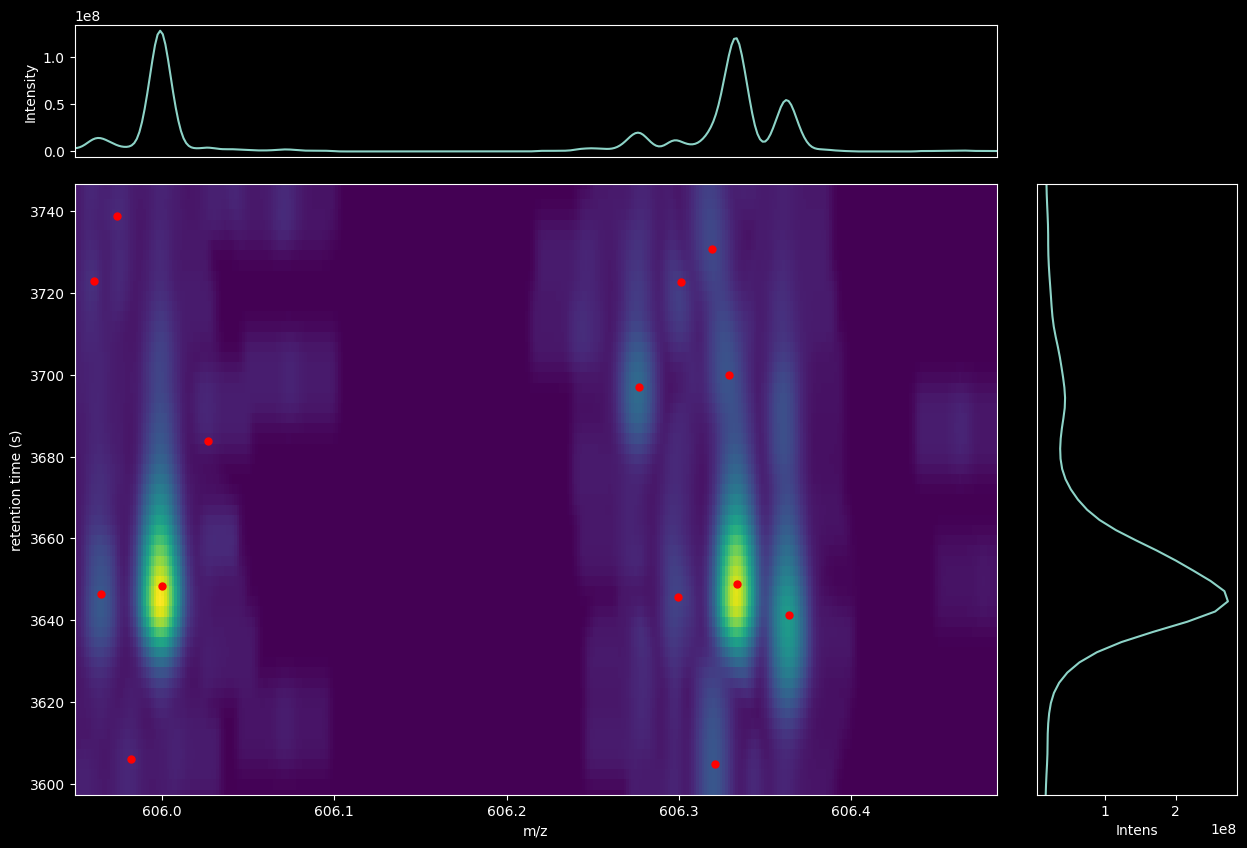

In [13]:
# Rereading the file with the mz and rt range zoomed to a peak area, same resampling data points as previous showing all detected peaks
lcmsData1r = pq.read_mzml(input_file = exampleFile1, min_mz = peaks1[peak1Idx].fitted_mz-mzm, max_mz = peaks1[peak1Idx].fitted_mz+mzp, min_rt = peaks1[peak1Idx].fitted_rt-rtm, max_rt = peaks1[peak1Idx].fitted_rt+rtp, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 1)
# resampling with 10 sampling points per peak
grid1r = pq.resample(lcmsData1r, 10, 10, 0.4, 0.4) #num_samples_mz, num_samples_rt, smoothing_coefficient_mz, smoothing_coefficient_rt
peaks1r = pq.find_peaks(lcmsData1r, grid1r, params['max_peaks'])
plot1r = pq.plot_mesh(grid1r, transform='sqrt', figure=None)
plot1r['img_plot'].get_figure().set_size_inches(15, 10)
xlim1r = plot1r['img_plot'].get_xlim()
ylim1r = plot1r['img_plot'].get_ylim()
mzVec1r = []
rtVec1r = []
print(peaks1r[0])
print('Number of peaks: ', len(peaks1r))
for i in range(len(peaks1r)):
    mzVec1r.insert(i, peaks1r[i].fitted_mz)
    rtVec1r.insert(i, peaks1r[i].fitted_rt)
plot1r['img_plot'].scatter(mzVec1r, rtVec1r, s=100, c='red', marker='.')

Peak <id: 0, local_max_mz: 605.999986, local_max_rt: 3646.350917, local_max_height: 11529259.780344, fitted_height: 15709154.430314, fitted_mz: 605.999714, fitted_rt: 3648.257465, fitted_sigma_mz: 0.005585, fitted_sigma_rt: 8.177359, fitted_volume: 4507497.341795>
Number of peaks:  16


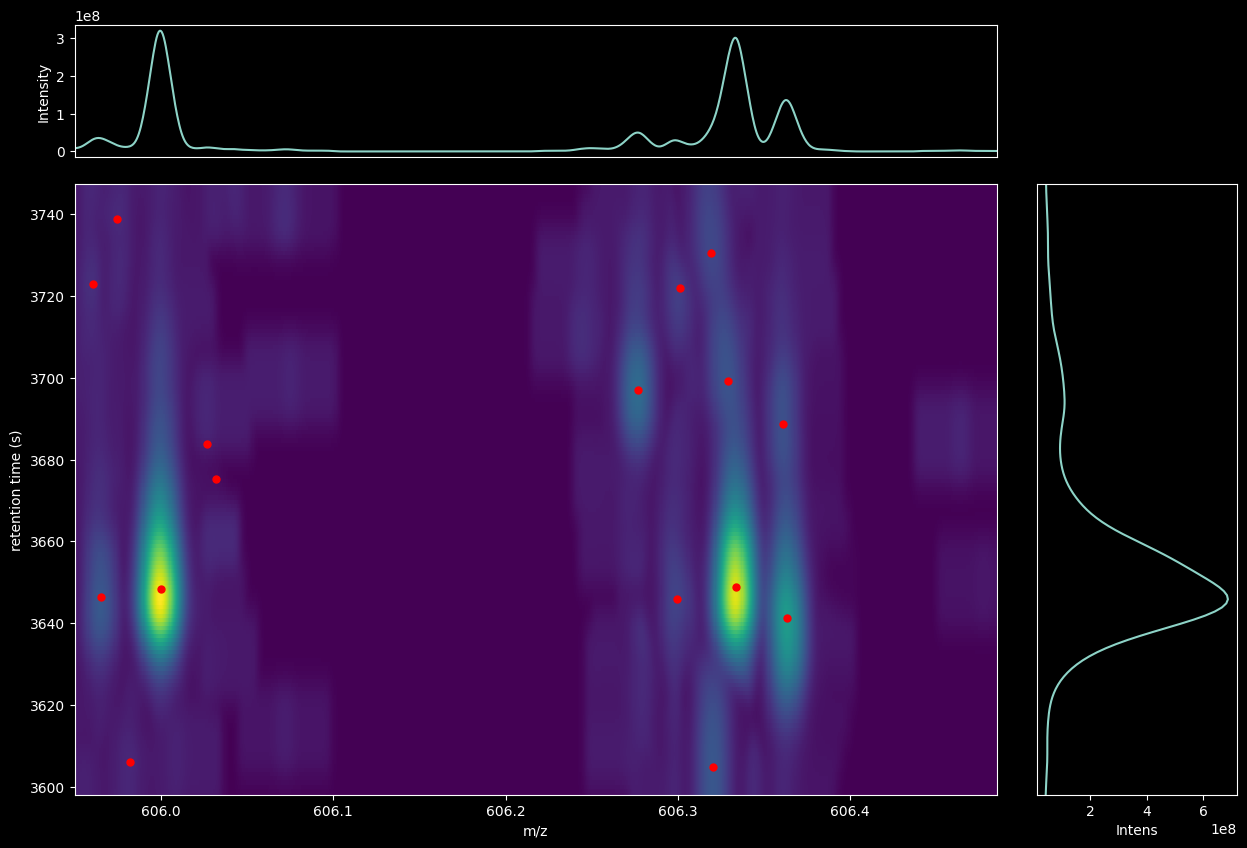

In [14]:
# resampling with 25 sampling points per peak
grid1r = pq.resample(lcmsData1r, 25, 25, 0.4, 0.4) #num_samples_mz, num_samples_rt, smoothing_coefficient_mz, smoothing_coefficient_rt
peaks1r = pq.find_peaks(lcmsData1r, grid1r, params['max_peaks'])
plot1r = pq.plot_mesh(grid1r, transform='sqrt', figure=None)
plot1r['img_plot'].get_figure().set_size_inches(15, 10)
xlim1r = plot1r['img_plot'].get_xlim()
ylim1r = plot1r['img_plot'].get_ylim()
mzVec1r = []
rtVec1r = []
print(peaks1r[0])
print('Number of peaks: ', len(peaks1r))
for i in range(len(peaks1r)):
    mzVec1r.insert(i, peaks1r[i].fitted_mz)
    rtVec1r.insert(i, peaks1r[i].fitted_rt)
plot1r['img_plot'].scatter(mzVec1r, rtVec1r, s=100, c='red', marker='.')